In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter, PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction
from FrequencyAbstraction import FourierTransformation
from sklearn.cluster import KMeans  

# Load data

In [4]:
# 1. Load the cleaned dataset (from the previous step)
# This file contains the data with outliers removed and gaps interpolated
df = pd.read_pickle("../../data/interim/02_outliers_removed_chauvenets.pkl")

# 2. Define the predictor columns
# We assume the first 6 columns are the sensors: acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z
predictor_columns = list(df.columns[:6])

# 3. Configure Plotting Settings
# These settings ensure all future plots in this notebook look consistent and professional
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)  # Wide charts
plt.rcParams["figure.dpi"] = 100          # High resolution
plt.rcParams["lines.linewidth"] = 2       # Thicker lines for visibility

# Dealing with missing values (imputation)


In [5]:
# Dealing with missing values (imputation)
for col in predictor_columns:
    df[col] = df[col].interpolate()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 739.0+ KB


# Calculating set duration


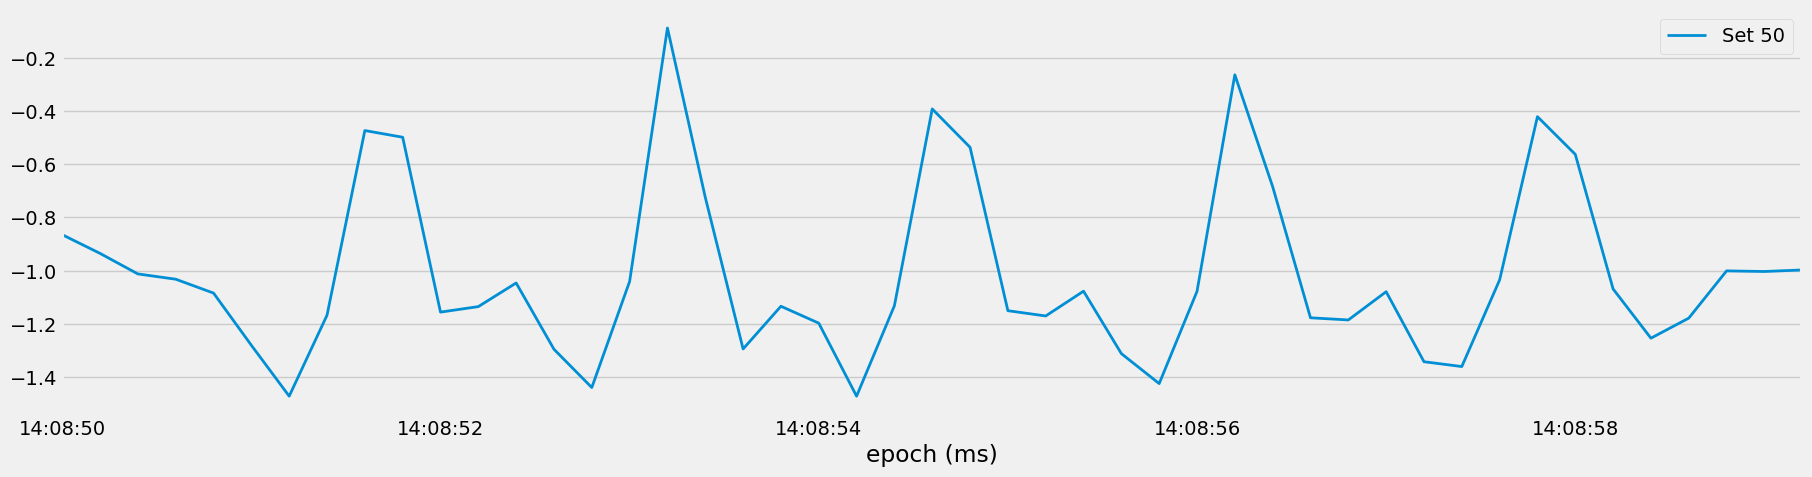

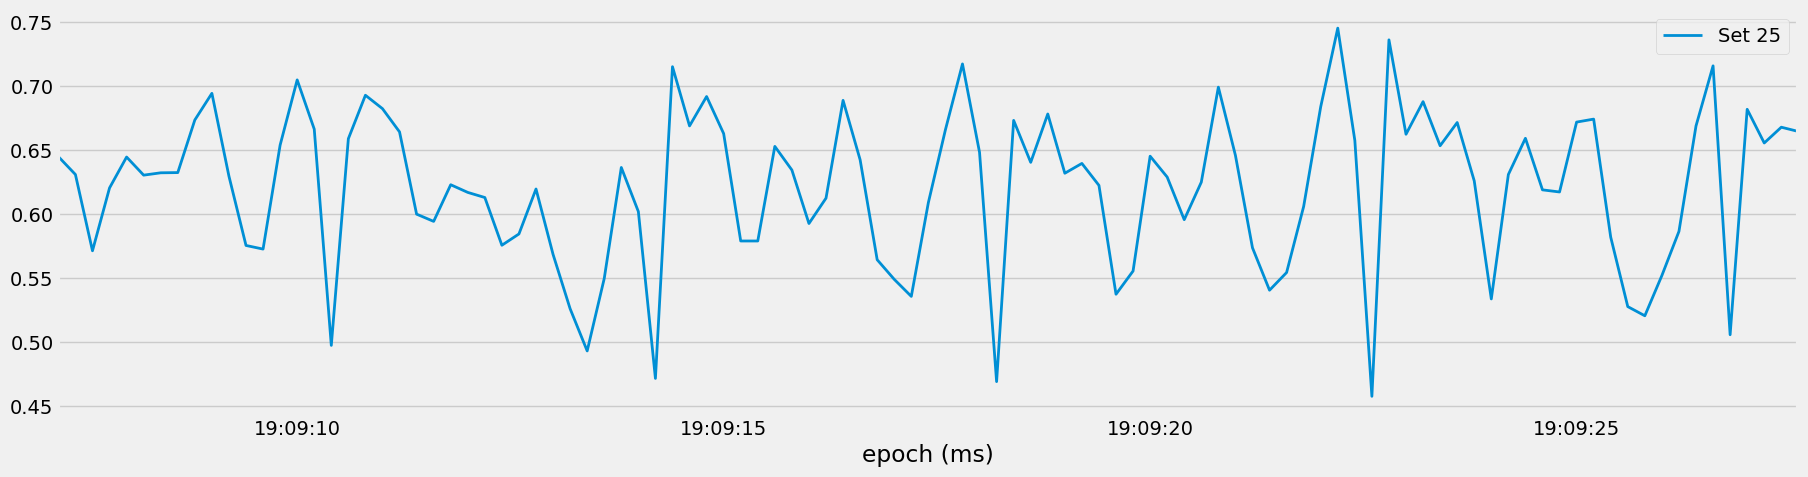

2.9487001733102254
2.4942528735632186
category
heavy       14.743501
medium      24.942529
sitting     33.000000
standing    39.000000
Name: duration, dtype: float64


In [6]:
# 1. Visualize specific sets to see the difference (e.g., Heavy vs Light)
# We plot the y-axis acceleration for set 25 and set 50 to compare them visually
df[df["set"] == 50]["acc_y"].plot(label="Set 50")
plt.legend()
plt.show()
df[df["set"] == 25]["acc_y"].plot(label="Set 25")
plt.legend()
plt.show()
# 2. Loop through every unique set to calculate its duration
for s in df["set"].unique():
    
    # Find the first and last timestamp for the current set 's'
    start = df[df["set"] == s].index[0]
    stop = df[df["set"] == s].index[-1]
    
    # Calculate the difference (duration)
    duration = stop - start
    
    # Save the duration (in seconds) to a new column "duration" for all rows in that set
    df.loc[(df["set"] == s), "duration"] = duration.seconds

# 3. Analyze the average duration per exercise category
duration_df = df.groupby(["category"])["duration"].mean()

# 4. Estimate time per repetition (Optional check)
# Assuming the first category (Heavy) had 5 reps and the second (Medium) had 10
# This prints the average seconds per rep to check if the data makes sense
print(duration_df.iloc[0] / 5)
print(duration_df.iloc[1] / 10)
print(duration_df)

# Butterworth lowpass filter

ohp


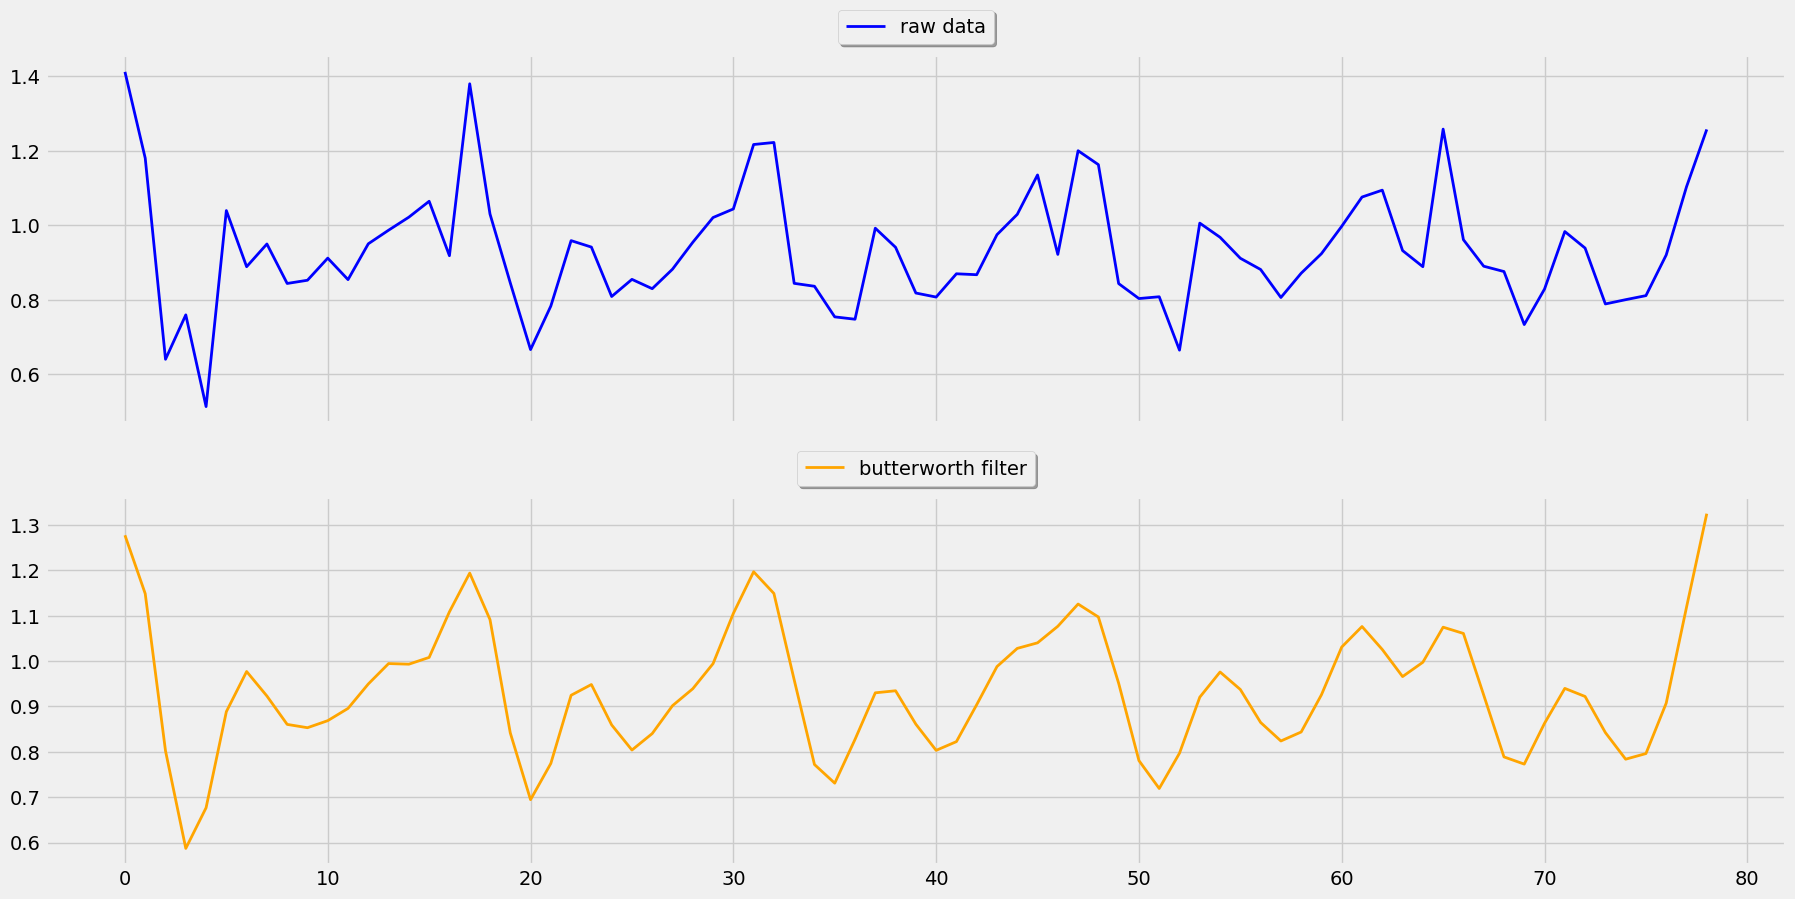

In [7]:
# 1. Setup the filter settings
df_lowpass = df.copy()
LowPass = LowPassFilter()
# Sampling frequency (fs)
# 1000 ms per second / 200 ms per sample = 5 Hz
fs = 1000 / 200 
cutoff = 1.2 # Cutoff frequency (1.2 Hz)
# 2. Test on a single column ("acc_y") and visualize
df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)
subset = df_lowpass[df_lowpass["set"] == 45]
print(subset["label"].iloc[0]) # Use .iloc[0] to safely get the first item
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="raw data", color="blue")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="butterworth filter", color="orange")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
plt.show()
# 3. Apply the filter to ALL predictor columns (The Loop)
for col in predictor_columns:
    # Apply filter to the current column (creates a new column like 'acc_x_lowpass')
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)
    # Overwrite the original noisy column with the clean filtered version
    df_lowpass[col] = df_lowpass[col + "_lowpass"]   
    # Delete the temporary "_lowpass" column to keep the dataframe clean
    del df_lowpass[col + "_lowpass"]

# Principal component analysis PCA

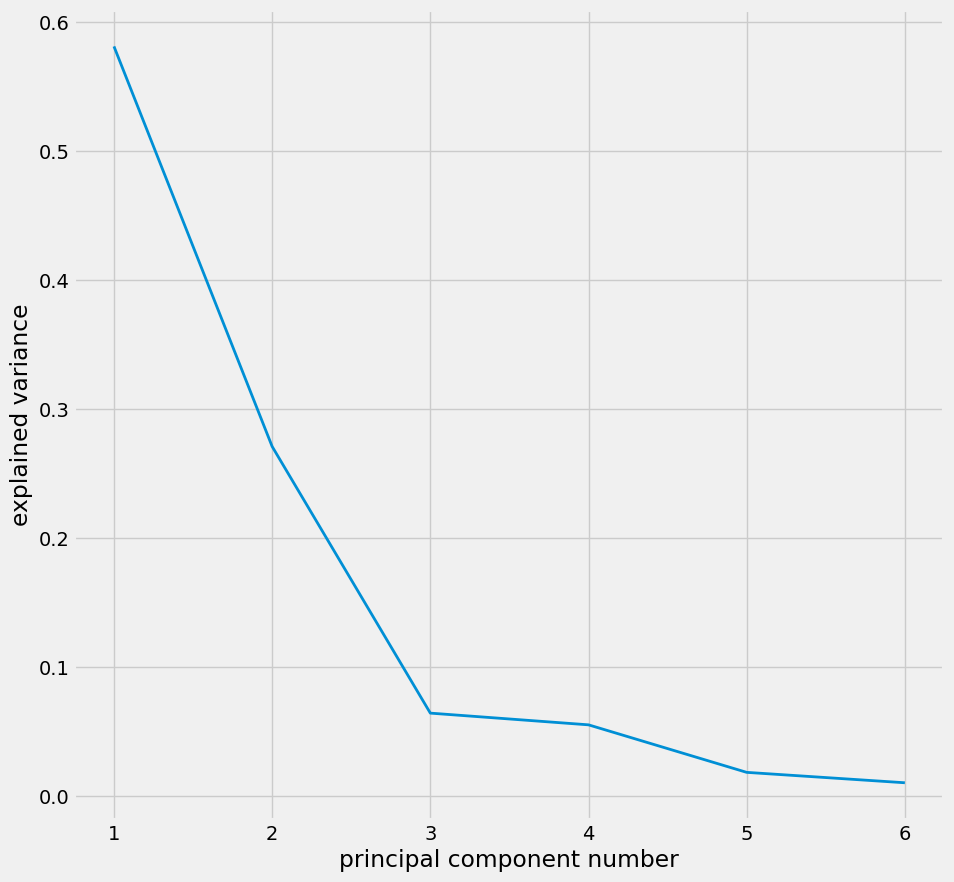

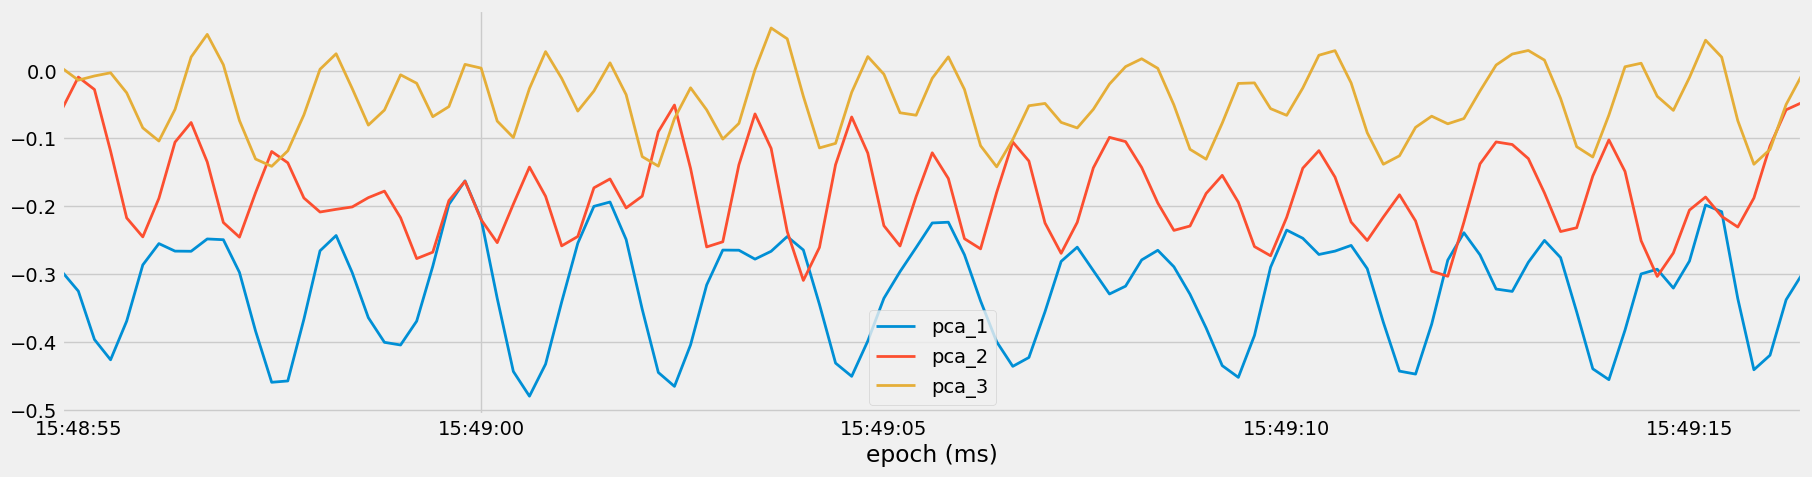

In [8]:
# 1. Initialize PCA
# We work on the low-pass filtered data to ensure we analyze signal, not noise
df_pca = df_lowpass.copy()
PCA = PrincipalComponentAnalysis()

# 2. Calculate the "Explained Variance" for every possible component
# This tells us how important each direction (component) is
pc_values = PCA.determine_pc_explained_variance(df_pca, predictor_columns)

# 3. Plot the "Scree Plot" (The Elbow Graph)
plt.figure(figsize=(10, 10))
plt.plot(range(1, len(predictor_columns) + 1), pc_values)
plt.xlabel("principal component number")
plt.ylabel("explained variance")
plt.show()

# 4. Apply the final PCA with the chosen number (3)
# This compresses your 6 sensor columns (acc_x...gyr_z) into 3 new columns (pca_1, pca_2, pca_3)
df_pca = PCA.apply_pca(df_pca, predictor_columns, 3)

# 5. Visualize the result for a specific set (e.g., Set 35)
subset = df_pca[df_pca["set"] == 35]
subset[["pca_1", "pca_2", "pca_3"]].plot()
plt.show()

# Sum of squares attributes


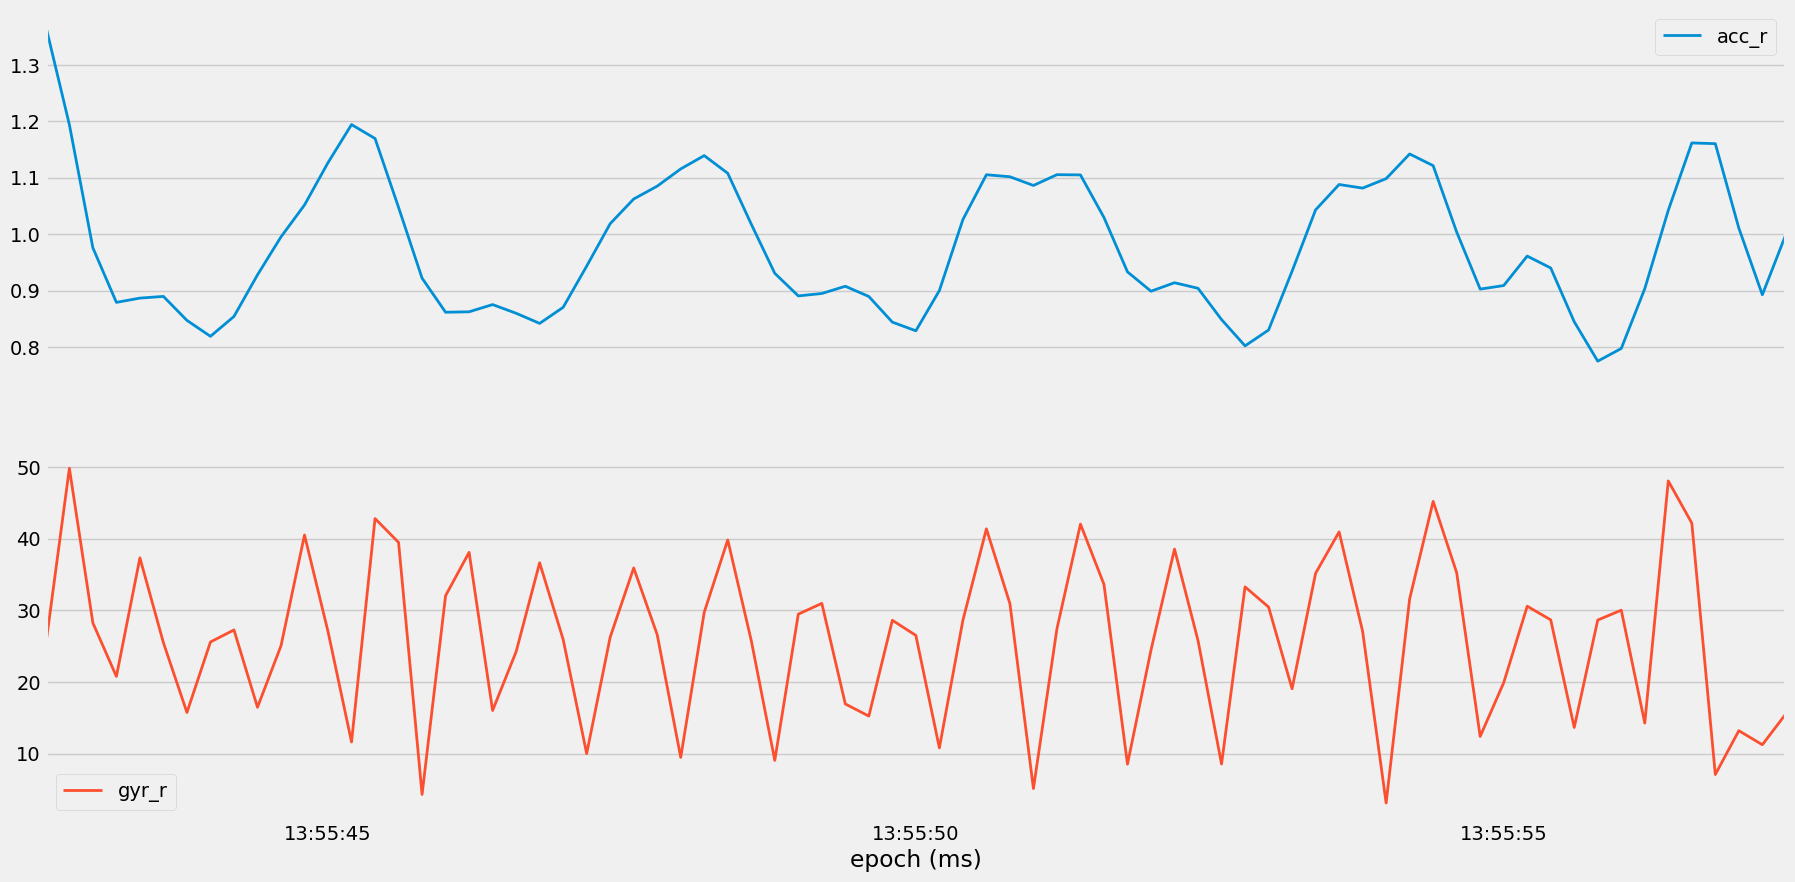

In [9]:
# 1. Create a copy for the new features
df_squared = df_pca.copy()

# 2. Calculate the Sum of Squares for Accelerometer
# Formula: r = sqrt(x^2 + y^2 + z^2)
acc_r = df_squared["acc_x"] ** 2 + df_squared["acc_y"] ** 2 + df_squared["acc_z"] ** 2
df_squared["acc_r"] = np.sqrt(acc_r)

# 3. Calculate the Sum of Squares for Gyroscope
gyr_r = df_squared["gyr_x"] ** 2 + df_squared["gyr_y"] ** 2 + df_squared["gyr_z"] ** 2
df_squared["gyr_r"] = np.sqrt(gyr_r)

# 4. Visualize the result
# Compare specific sets (e.g., Set 14) to see the combined intensity
subset = df_squared[df_squared["set"] == 14]

subset[["acc_r", "gyr_r"]].plot(subplots=True, figsize=(20, 10))
plt.show()

# Temporal abstraction

<AxesSubplot: xlabel='epoch (ms)'>

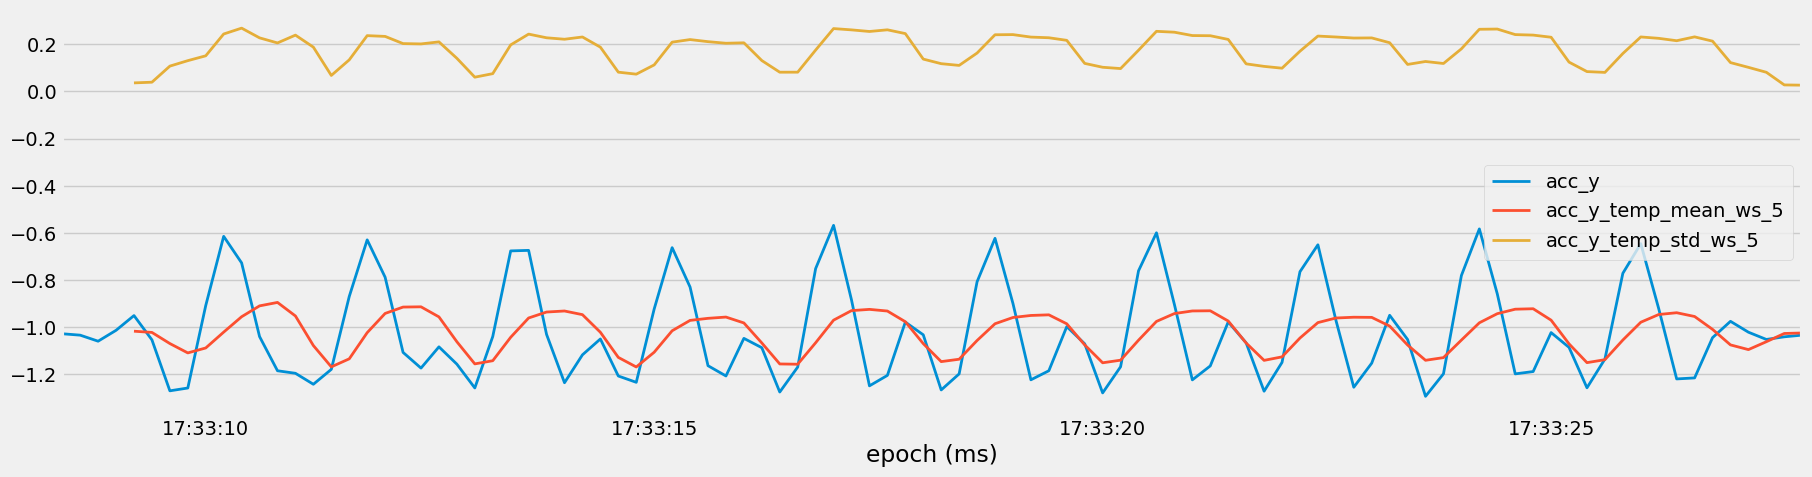

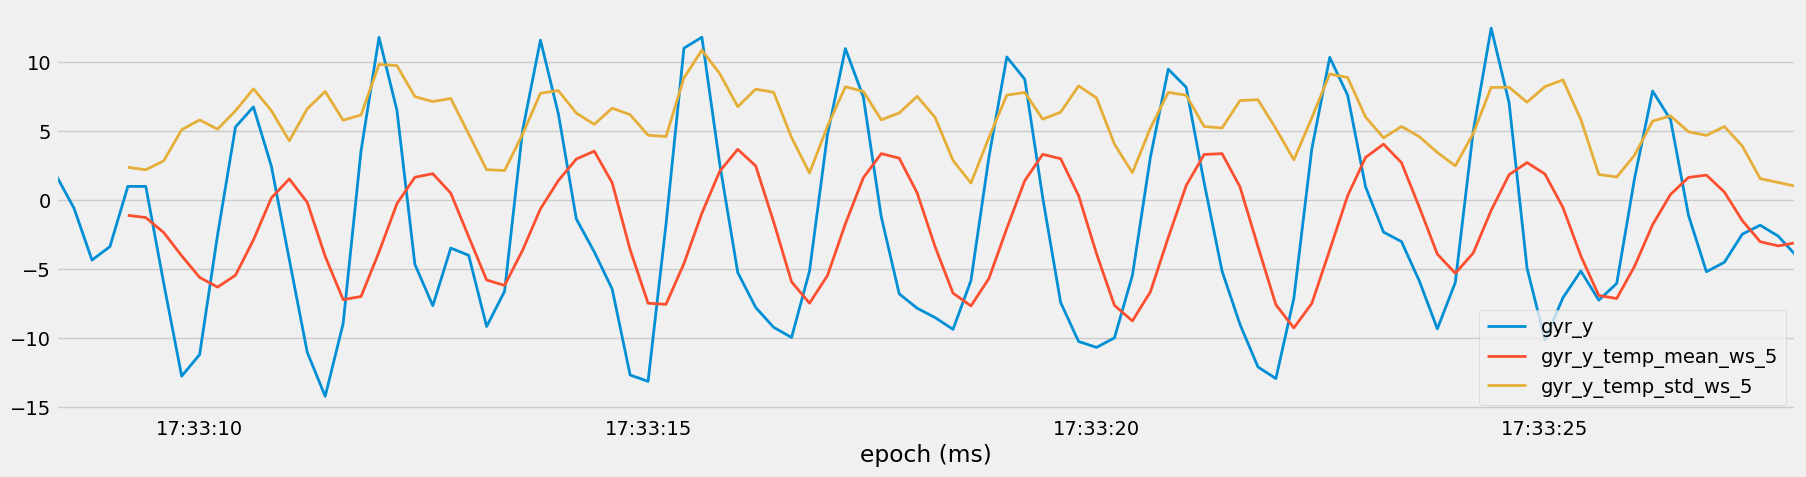

In [10]:
df_temporal = df_squared.copy()
NumAbs = NumericalAbstraction()

predictor_columns = predictor_columns + ["acc_r", "gyr_r"]

ws = int(1000 / 200)

for col in predictor_columns:
    df_temporal = NumAbs.abstract_numerical(df_temporal, [col], ws, "mean")
    df_temporal = NumAbs.abstract_numerical(df_temporal, [col], ws, "std")

df_temporal_list = []
for s in df_temporal["set"].unique():
    subset = df_temporal[df_temporal["set"] == s].copy()
    for col in predictor_columns:
        subset = NumAbs.abstract_numerical(subset, [col], ws, "mean")
        subset = NumAbs.abstract_numerical(subset, [col], ws, "std")
    df_temporal_list.append(subset)

df_temporal = pd.concat(df_temporal_list)

subset[["acc_y", "acc_y_temp_mean_ws_5", "acc_y_temp_std_ws_5"]].plot()
subset[["gyr_y", "gyr_y_temp_mean_ws_5", "gyr_y_temp_std_ws_5"]].plot()

# Frequency features


Applying Fourier transformations to set 30
Applying Fourier transformations to set 1
Applying Fourier transformations to set 31
Applying Fourier transformations to set 3
Applying Fourier transformations to set 9
Applying Fourier transformations to set 32
Applying Fourier transformations to set 10
Applying Fourier transformations to set 33
Applying Fourier transformations to set 11
Applying Fourier transformations to set 34
Applying Fourier transformations to set 35
Applying Fourier transformations to set 15
Applying Fourier transformations to set 36
Applying Fourier transformations to set 16
Applying Fourier transformations to set 37
Applying Fourier transformations to set 17
Applying Fourier transformations to set 27
Applying Fourier transformations to set 38
Applying Fourier transformations to set 28
Applying Fourier transformations to set 29
Applying Fourier transformations to set 6
Applying Fourier transformations to set 65
Applying Fourier transformations to set 67
Applying Fourie

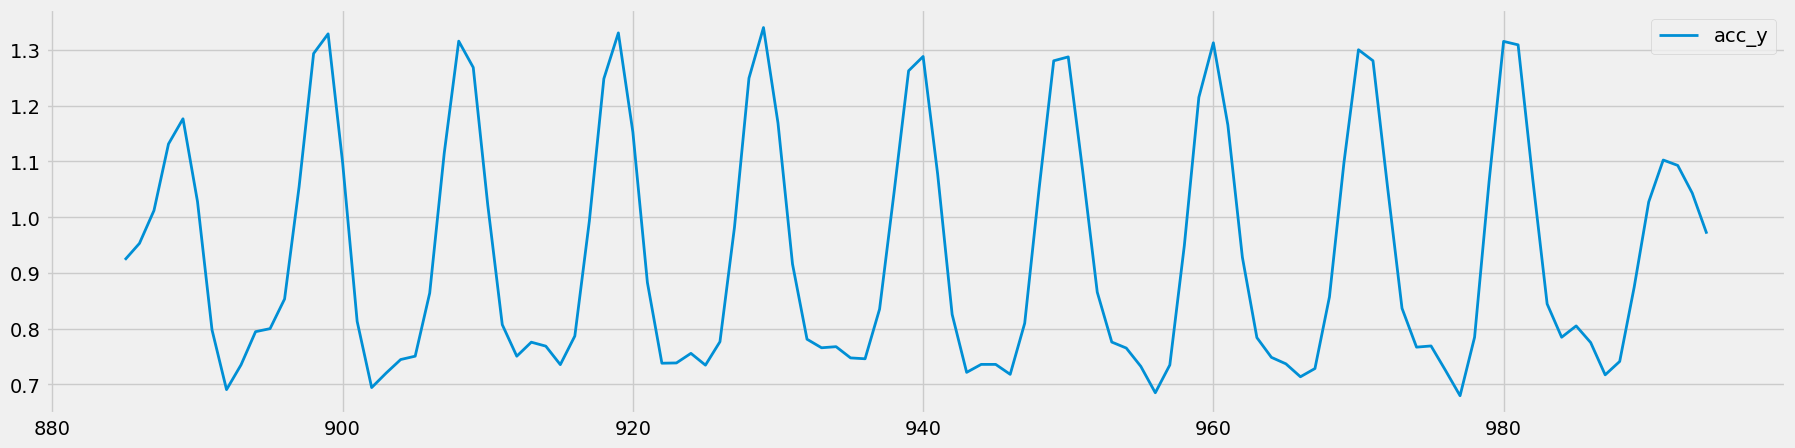

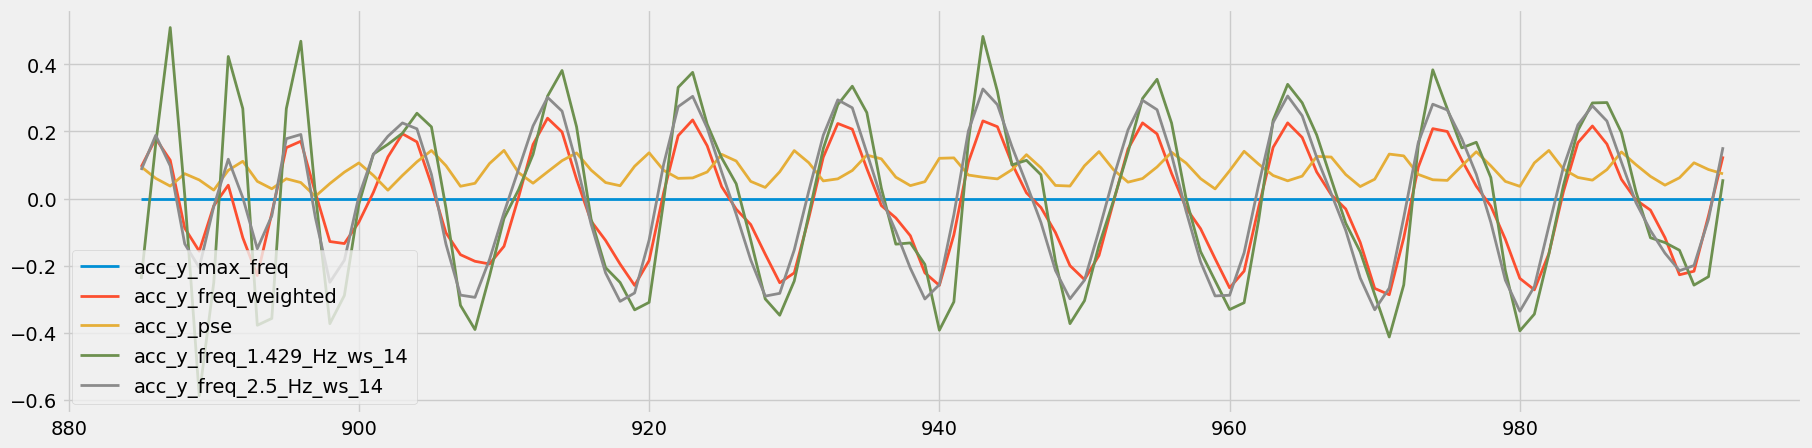

In [12]:
df_freq = df_temporal.copy().reset_index()
FreqAbs = FourierTransformation()
fs = int(1000 / 200)  # Sampling frequency (1000ms / 200ms)
ws = int(2800 / 200)  # Window size (2800ms / 200ms)
# Initial test run on one column (optional, usually skipped for the loop)
df_freq = FreqAbs.abstract_frequency(df_freq, ["acc_y"], ws, fs)
# Visualize results

subset = df_freq[df_freq["set"] == 15]
subset[["acc_y"]].plot()
subset[
    [
        "acc_y_max_freq",
        "acc_y_freq_weighted",
        "acc_y_pse",
        "acc_y_freq_1.429_Hz_ws_14",
        "acc_y_freq_2.5_Hz_ws_14",
    ]
].plot()
# Apply to all sets (Loop to prevent data leakage)
df_freq_list = []
for s in df_freq["set"].unique():
    print(f"Applying Fourier transformations to set {s}")
    subset = df_freq[df_freq["set"] == s].reset_index(drop=True).copy()
    subset = FreqAbs.abstract_frequency(subset, predictor_columns, ws, fs)
    df_freq_list.append(subset)

df_freq = pd.concat(df_freq_list).set_index("epoch (ms)", drop=True)

# Dealing with overlapping windows

In [13]:
df_freq = df_freq.dropna()
df_freq = df_freq.iloc[::2]

# clustering

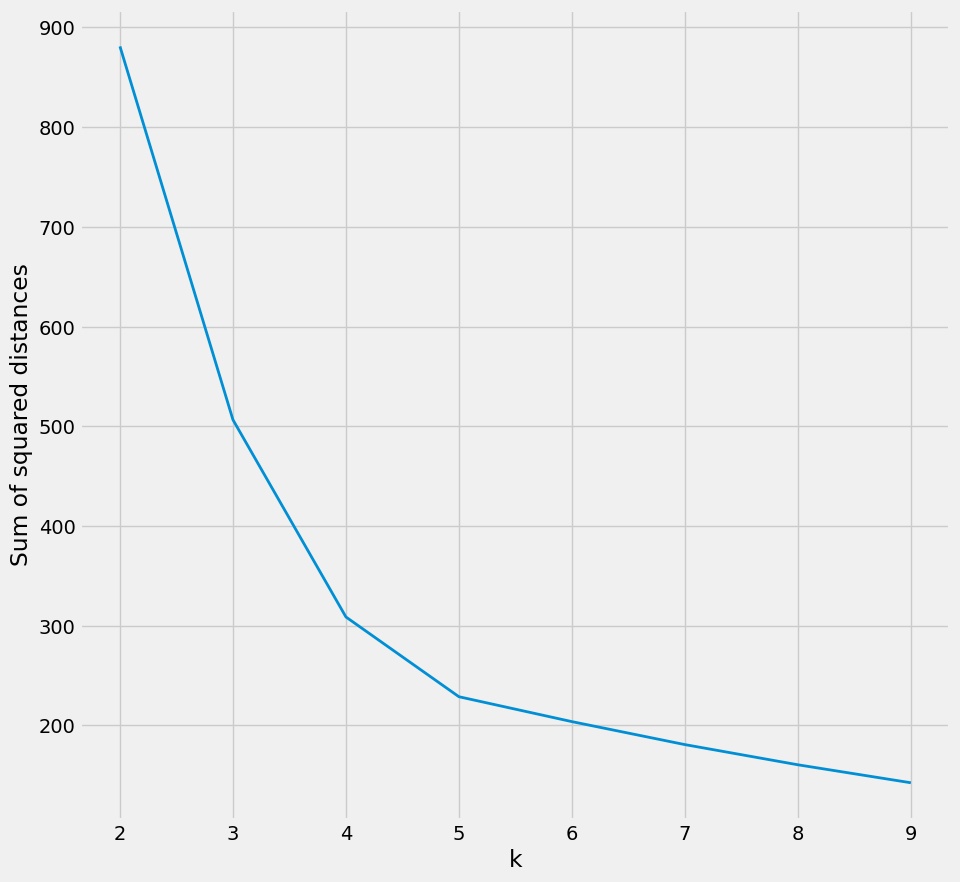

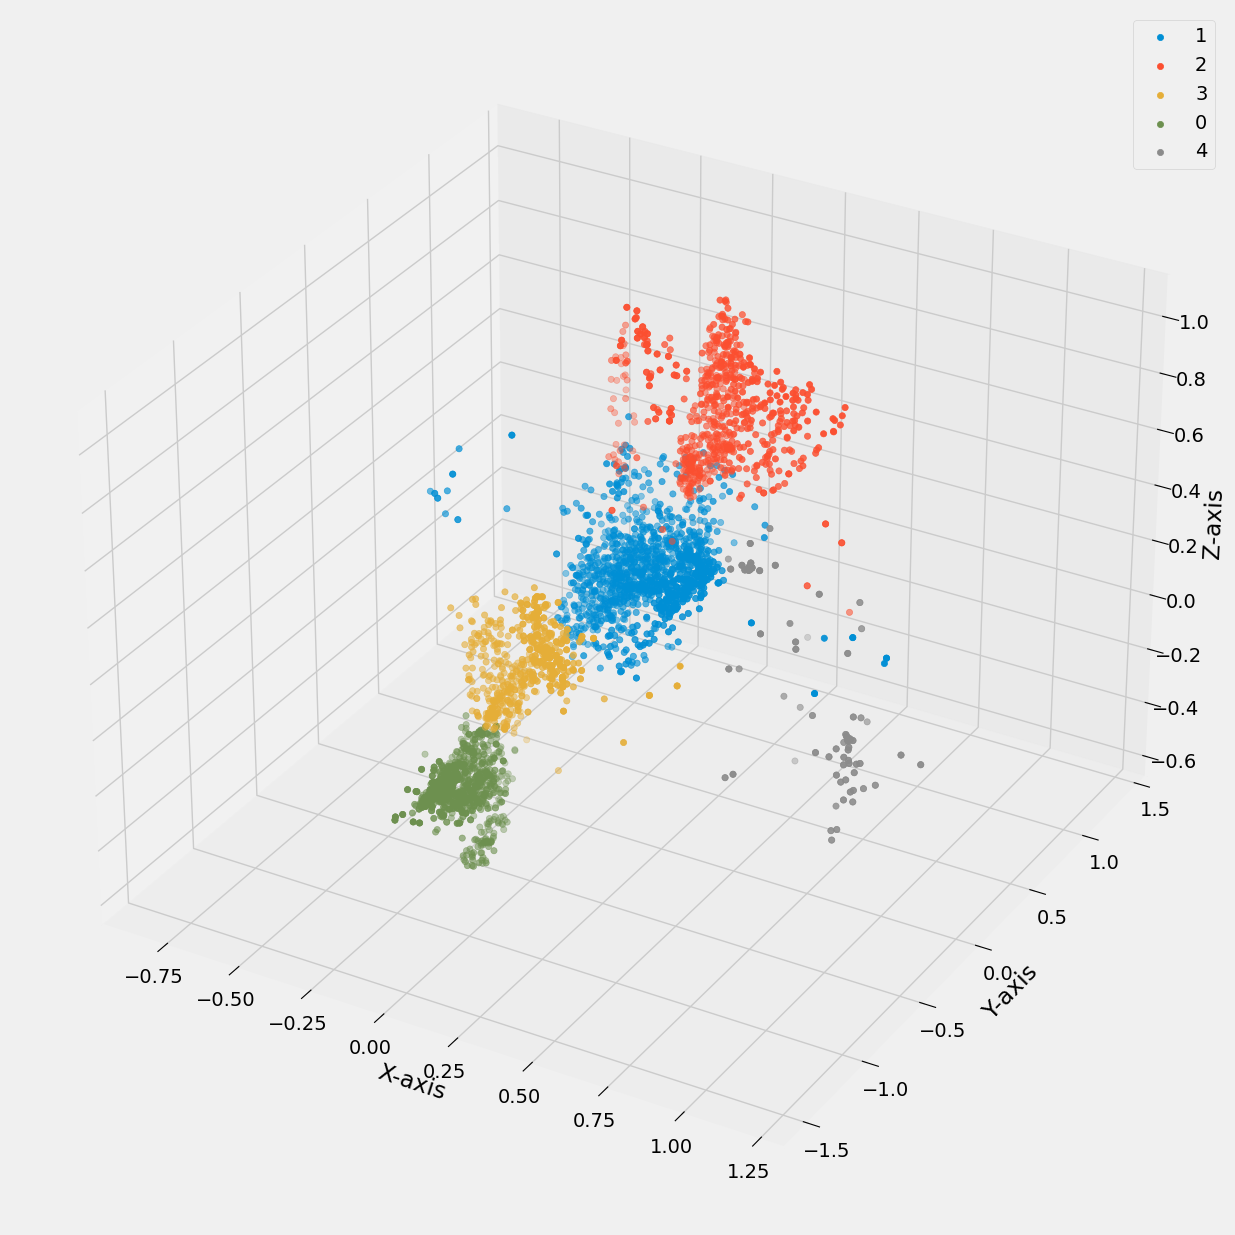

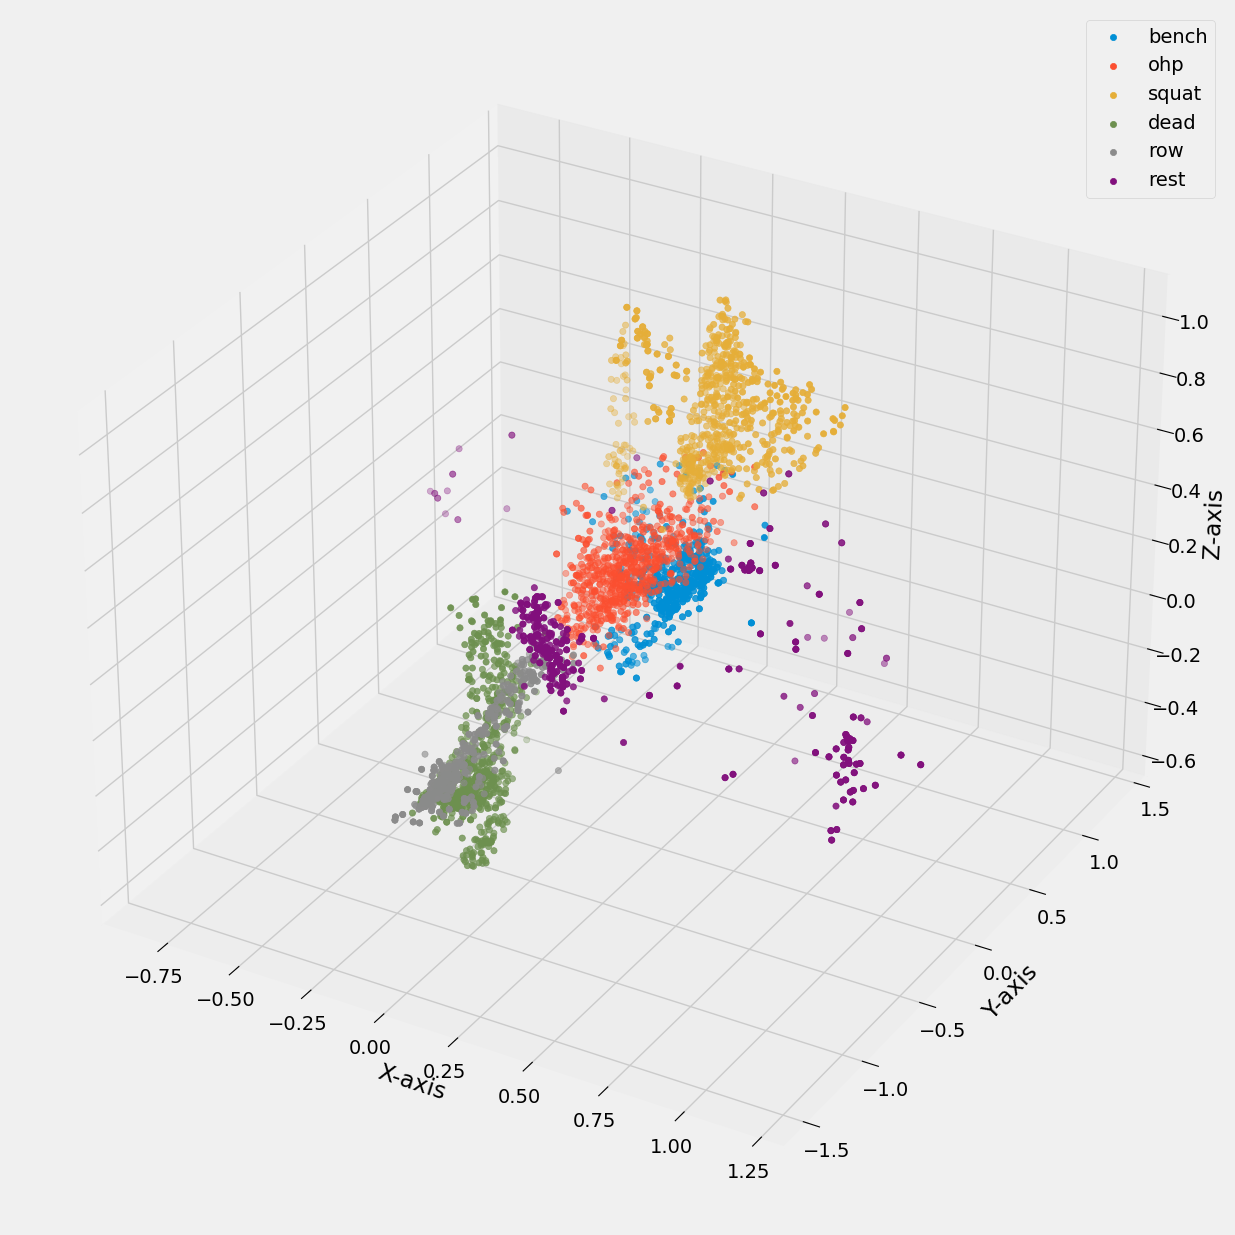

In [15]:


df_cluster = df_freq.copy()

cluster_columns = ["acc_x", "acc_y", "acc_z"]
k_values = range(2, 10)
inertias = []

# 1. Elbow Method to find the optimal k
for k in k_values:
    subset = df_cluster[cluster_columns]
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=0)
    cluster_labels = kmeans.fit_predict(subset)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 10))
plt.plot(k_values, inertias)
plt.xlabel("k")
plt.ylabel("Sum of squared distances")
plt.show()

# 2. Apply Clustering (assuming k=5 based on the elbow plot)
kmeans = KMeans(n_clusters=5, n_init=20, random_state=0)
subset = df_cluster[cluster_columns]
df_cluster["cluster"] = kmeans.fit_predict(subset)

# 3. Plot clusters (What the algorithm found)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")
for c in df_cluster["cluster"].unique():
    subset = df_cluster[df_cluster["cluster"] == c]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label=c)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()

# 4. Plot accelerometer data to compare (The Ground Truth)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")
for l in df_cluster["label"].unique():
    subset = df_cluster[df_cluster["label"] == l]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label=l)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()


# Export dataset

In [18]:
df_cluster.to_pickle("../../data/interim/03_feature_engineered_dataset.pkl")